This notebook uses a pre-trained convolutional network (VGG16) to extract feature vectors from images. These vectors are then fed into a DBSCAN clustering algorithm to detect clusters of vectors, each cluster representing a group of similar looking images.

In [1]:
import keras
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.models import Model

from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

### Preparing the dataset
I used images from my phone because I knew that there would be similar looking images present due to burst shots. Plus it's more fun to work with :D

In [2]:
# Get list of image paths
folder_path = './101APPLE_IMAGES/'

possible_extensions = ('.jpg', '.JPG', '.png', '.PNG', '.jpeg', '.JPEG')
all_images = [name for name in os.listdir(folder_path) if name.endswith(possible_extensions)] 
print(f'Number of images: {len(all_images)}')

Number of images: 905


### Loading pre-trained model
I decided to use the VGG16 model with pre-trained weights. The VGG16 model is a highly effective image classifier trained on the ImageNet database. I expect that the classifier must form a very effective representation of the image in order to be able to classify it with such high accuracy, hence I can use this to my advantage by re-purposing this for another task.

The way I do this is by instantiating a new model called `feature_extractor` which takes a reference to the desired input and output in the VGG16 model. Thus, `feature_extractor`'s output is the layer just before the classification, the last 4096-neuron fully connected layer.

In [3]:
# Load VGG16 model and view its architecture 
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
# VGG16 model without soft-max layer
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)

In order to input an image into the model, it has to be pre-processed into a feature vector of the correct size. To do this, I create a function `load_image(path)` which will handle the usual pre-processing steps: load an image from my file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [5]:
# Function to load image
def load_image(path):
    '''
    Takes in an image path
    Outputs image and image array 
    '''
    img = image.load_img(path, target_size=model.input_shape[1:3])
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = preprocess_input(arr)
    return img, arr

Shape of array:  (1, 224, 224, 3)
Data type:  float32


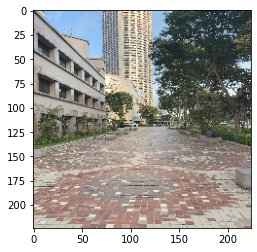

In [6]:
# Example of loading an image
img, arr = load_image(f'{folder_path}{all_images[101]}')
print("Shape of array: ", arr.shape)
print("Data type: ", arr.dtype)
plt.imshow(img)
plt.show()

By using the `predict` function of `feat_extractor`, I can get feature vector representations of arrays passed into it. There are 4096 dimensions, which corresponds to `feature_extractor`'s 4096-neuron fully connected output layer. This graph shows the activation levels of each dimension for this array.

Number of dimensions: 4096


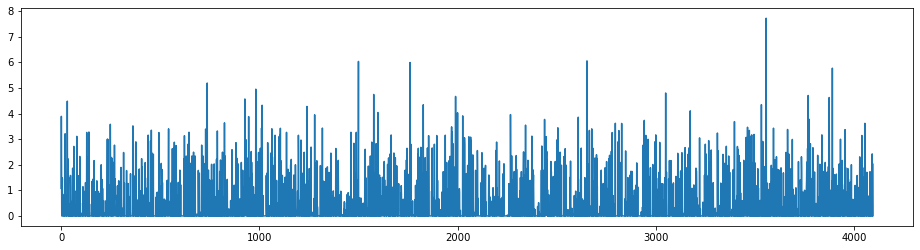

In [7]:
# Feature vector representation
feat = feat_extractor.predict(arr)
print(f'Number of dimensions: {len(feat[0])}')
plt.figure(figsize=(16,4))
plt.plot(feat[0])
plt.show()

Now I create feature vector representations for every image in my dataset.

In [8]:
features = []

for i, image_path in enumerate(all_images):
    if i%100 == 0:
        print(f'now at image {i}...') 
    img, x = load_image(f'{folder_path}{image_path}');
    feat = feat_extractor.predict(x)[0]
    features.append(feat)
print('Completed')

now at image 0...
now at image 100...


/Users/jameslim/miniforge3/envs/ml/lib/python3.8/site-packages/PIL/Image.py:2847: DecompressionBombWarning: Image size (118293718 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


now at image 200...
now at image 300...
now at image 400...
now at image 500...
now at image 600...
now at image 700...
now at image 800...
now at image 900...
Completed


### Clustering
Before feeding these feature vectors into the DBSCAN clustering algorithm, I use Princical Component Analysis (PCA) to reduce the number of dimensions so that I can remove correlated features and thus leave the clustering algorithm with lesser input dimensions to account for.

As PCA is a variance maximizing operation, I scale my features before proceeding with PCA so that I avoid the scenario where one or a few single principal components explain most of the variation in the data. Instead, I want other components to contribute as much as possible too.

In [9]:
# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

`explained_var` is the parameter that tells PCA to choose the number of principal components that explain a certain amount of variation in the data. For example, here I tell PCA to select the number of principal components that account for `90%` of the variation seen in my data, resulting in `339` principal components chosen.

In [10]:
# Dimension reduction
explained_var = 0.90

pca = PCA(n_components = explained_var)
pca_features = pca.fit_transform(features_scaled)
print(f"Number of components chosen: {len(pca.components_)}")

Number of components chosen: 339


`eps` represents epsilon, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. Its an arbitary distance that varies largely based on your dataset, but I found that using a value of `30` gave me pretty decent results (by visual inspection).

The end product is `clusters_found`, a dictionary containing the clusters identified by the algorithm. 

In [11]:
# Clustering
eps = 30

cluster = DBSCAN(eps=eps, min_samples=2).fit(pca_features)
clusters_found = defaultdict(list)
for i, n in enumerate(cluster.labels_):
    clusters_found[int(n)].append(all_images[i])

if -1 in clusters_found:
    del clusters_found[-1]
    
# Model-identified clusters
clusters_found = dict(clusters_found)
clusters_found

{0: ['837.JPG', '142.PNG'],
 1: ['412.PNG', '411.PNG'],
 2: ['604.JPG', '605.JPG', '603.JPG'],
 3: ['610.JPG', '611.JPG', '607.JPG', '612.JPG', '608.JPG', '609.JPG'],
 4: ['360.JPG', '359.JPG'],
 5: ['566.PNG',
  '413.PNG',
  '405.PNG',
  '161.PNG',
  '565.JPG',
  '571.PNG',
  '203.PNG',
  '570.PNG',
  '376.PNG',
  '410.PNG',
  '75.JPG',
  '574.PNG',
  '628.PNG',
  '833.JPG',
  '459.PNG',
  '505.PNG',
  '504.PNG',
  '458.PNG',
  '314.PNG',
  '506.PNG',
  '530.PNG',
  '532.PNG',
  '320.PNG',
  '23.JPG',
  '319.PNG',
  '534.PNG',
  '382.PNG',
  '631.PNG',
  '585.PNG',
  '383.PNG',
  '168.PNG',
  '632.PNG',
  '587.PNG',
  '586.PNG',
  '579.PNG',
  '409.PNG',
  '384.PNG',
  '568.PNG',
  '92.JPG',
  '594.PNG',
  '392.PNG'],
 6: ['214.PNG', '371.PNG'],
 7: ['215.PNG',
  '175.PNG',
  '564.PNG',
  '321.PNG',
  '32.JPG',
  '483.PNG',
  '180.PNG',
  '209.PNG',
  '208.PNG',
  '424.PNG',
  '381.PNG',
  '578.PNG'],
 8: ['229.JPG', '230.JPG'],
 9: ['361.JPG', '362.JPG'],
 10: ['349.JPG', '327.JPG', 

### Inspecting results
Lets take a look at the results. The function `display_neighbors` displays images identified by the algorithm to be in the same cluster, or in other words, similar looking images.

In [12]:
# Display images in a cluster
def display_neighbors(cluster):
    '''
    Takes in a list of image names
    Displays images in the list 
    '''
    pics = []
    pic_names = []
    for i in cluster:
        pic_names.append(i)
        img = image.load_img(f'{folder_path}/{i}')
        img = img.resize((int(img.width*100/img.height), 100))
        pics.append(img)
    
    output = np.concatenate([np.asarray(t) for t in pics], axis = 1)
    plt.figure(figsize = (12,8))
    plt.imshow(output)
    plt.show()
    return

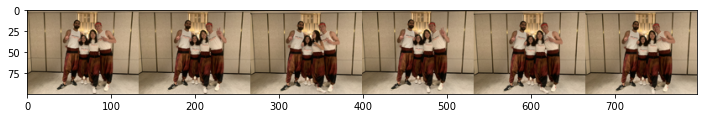

In [14]:
display_neighbors(clusters_found[3])

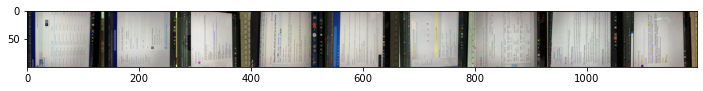

In [21]:
display_neighbors(clusters_found[19])

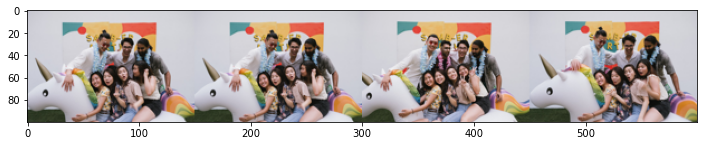

In [17]:
display_neighbors(clusters_found[10])

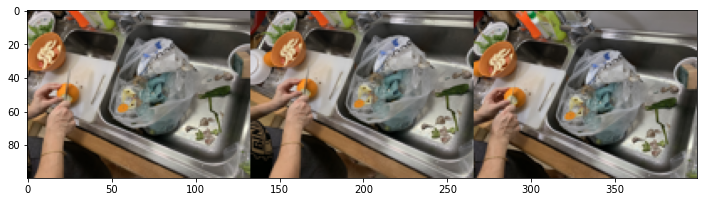

In [34]:
display_neighbors(clusters_found[55])

THE END